In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import fetch_california_housing
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap
from sklearn.inspection import permutation_importance
from PyALE import ale
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score

In [2]:
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

train_adult = pd.read_csv("DataSets/census/adult.data", header=None, names=columns, sep=",", na_values=" ?", skipinitialspace=True)
test_adult = pd.read_csv("DataSets/census/adult.test", header=0, names=columns, sep=",", na_values=" ?", skipinitialspace=True, comment='|')
test_adult['income'] = test_adult['income'].str.replace('.', '', regex=False)

data_adult = pd.concat([train_adult, test_adult], ignore_index=True).dropna()


In [47]:
housing = fetch_california_housing()

X = housing.data
y = housing.target

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nFeature names:")
print(housing.feature_names)

Features (X) shape: (20640, 8)
Target (y) shape: (20640,)

Feature names:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


# Part 1: Feature-Level Interpretability (30 marks)  
You will use the California Housing and the Adult Census Income datasets in this part. You 
should train one feed-forward neural network for each dataset and apply the following 
interpretability techniques:

In [7]:
# Adult Census Income Dataset pre-processing and neural network model

X_adult = data_adult.drop("income", axis=1)
y_adult = (data_adult["income"] == ">50K").astype(int)

# Identify categorical and numerical columns
cat_cols = X_adult.select_dtypes(include=['object']).columns
num_cols = X_adult.select_dtypes(exclude=['object']).columns

# Encode categorical & scale numeric
ct = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('scale', StandardScaler(), num_cols)
])

X_processed_adult = ct.fit_transform(X_adult)
X_train_adult, X_val_adult, y_train_adult, y_val_adult = train_test_split(X_processed_adult, y_adult, test_size=0.2, random_state=42)

input_dim = X_train_adult.shape[1]

# The feed-forward neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(
    X_train_adult, y_train_adult,
    validation_data=(X_val_adult, y_val_adult),
    epochs=10,
    batch_size=256,
    verbose=1
)

# Evaulate the model
loss, acc = model.evaluate(X_val_adult, y_val_adult, verbose=0)
print(f"Validation Accuracy: {acc:.4f}")

Epoch 1/10


c:\Users\jamie\OneDrive\Desktop\Interpretable AI Project\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7881 - loss: 0.4447 - val_accuracy: 0.8539 - val_loss: 0.3168
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8530 - loss: 0.3196 - val_accuracy: 0.8552 - val_loss: 0.3121
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8553 - loss: 0.3113 - val_accuracy: 0.8576 - val_loss: 0.3095
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8589 - loss: 0.3074 - val_accuracy: 0.8575 - val_loss: 0.3077
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8579 - loss: 0.3073 - val_accuracy: 0.8584 - val_loss: 0.3081
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8606 - loss: 0.3047 - val_accuracy: 0.8594 - val_loss: 0.3061
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8591 - loss: 0.3059 - val_accuracy: 0.8584 - val_loss: 0.3073
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8607 - loss: 0.3010 - val_accuracy: 0.8598 - val_

"\n\nfrom scikeras.wrappers import KerasClassifier\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.preprocessing import OneHotEncoder, StandardScaler\nfrom sklearn.inspection import PartialDependenceDisplay\nimport matplotlib.pyplot as plt\n\n# Wrap the Keras model\ndef create_model():\n    model = Sequential([\n        Dense(128, activation='relu', input_dim=input_dim),\n        Dropout(0.3),\n        Dense(64, activation='relu'),\n        Dropout(0.3),\n        Dense(1, activation='sigmoid')\n    ])\n    model.compile(optimizer=Adam(learning_rate=0.001),\n                  loss='binary_crossentropy', metrics=['accuracy'])\n    return model\n\n# Wrap in scikit-learn compatible estimator\nsklearn_model = KerasClassifier(model=create_model, epochs=10, batch_size=256, verbose=0)\nsklearn_model.fit(X_train_adult, y_train_adult)  # Train the model\n"

In [48]:
# California Housing Dataset pre-processing and neural network model

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"Total data points: {len(X)}")
print(f"Training data points: {len(X_train)}")
print(f"Validation data points: {len(X_valid)}")
print(f"Test data points: {len(X_test)}")


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

print("Data successfully scaled")
print(f"Original mean (first feature): {X_train[:, 0].mean():.4f}")
print(f"Scaled mean (first feature): {X_train_scaled[:, 0].mean():.4f}")


def create_model():

    n_features = X_train_scaled.shape[1]

    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=[X_train_scaled.shape[1]]),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dense(1)
    ])
    
    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=["mean_absolute_error"]
    )
    
    return model

model = KerasRegressor(
    model=create_model,
    verbose=0
)

print("Keras Wrapper created successfully")

print("Model compiled with MSE as the loss function and Dropout Layers and a custom Adam.")

print("--- Starting Model Training ---")

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[early_stopping],
    verbose=1
)

print("--- Model Training Finished ---")

print("--- Evaluating Model on Test Set ---")

y_pred = model.predict(X_test_scaled)

final_mse = mean_squared_error(y_test, y_pred)
final_mae = mean_absolute_error(y_test, y_pred)

print(f"Final Test Set MSE (Mean Squared Error): {final_mse:.4f}")
print(f"Final Test Set MAE (Mean Absolute Error): {final_mae:.4f}")

Total data points: 20640
Training data points: 13209
Validation data points: 3303
Test data points: 4128
Data successfully scaled
Original mean (first feature): 3.8689
Scaled mean (first feature): -0.0000
Keras Wrapper created successfully
Model compiled with MSE as the loss function and Dropout Layers and a custom Adam.
--- Starting Model Training ---
Epoch 1/100


c:\UoM\Year 3\ARI3205 Interpretable AI for DL Models\interpretableaiproject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0035 - mean_absolute_error: 0.7077 - val_loss: 0.4784 - val_mean_absolute_error: 0.4822
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5294 - mean_absolute_error: 0.5197 - val_loss: 0.4094 - val_mean_absolute_error: 0.4581
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4695 - mean_absolute_error: 0.4905 - val_loss: 0.4638 - val_mean_absolute_error: 0.4559
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4441 - mean_absolute_error: 0.4733 - val_loss: 0.4095 - val_mean_absolute_error: 0.4539
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4124 - mean_absolute_error: 0.4592 - val_loss: 0.3839 - val_mean_absolute_error: 0.4462
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4069 - mean_absolute_error: 0.4564 - val_loss: 0.3914 - val_mean_absolute_error: 0.4346
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3893 - mean_absolute_error: 0.4439 - val_lo

## 1. Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots (7 marks) 
### a. Use PDP to examine the average effect of at least two features. 

In [44]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Select only numeric features for PDP
X_train_numeric = X_train_adult[:, -len(num_cols):]  # last columns are scaled numeric
numeric_feature_names = list(num_cols)  # ['age', 'fnlwgt', 'education-num', ...]

# Wrap your trained model
class KerasWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        return self

    def predict_proba(self, X):
        probs = self.model.predict(X, verbose=0).flatten()
        return np.vstack([1 - probs, probs]).T

wrapped_model = KerasWrapper(model)
wrapped_model.fit(X_train_numeric)

# Pick features: 'age' and 'hours-per-week'
features_for_pdp = ['age', 'hours-per-week']
feature_indices = [numeric_feature_names.index(f) for f in features_for_pdp]

# Plot PDP
PartialDependenceDisplay.from_estimator(
    wrapped_model,
    X_train_numeric,
    features=feature_indices,
    feature_names=numeric_feature_names,
    grid_resolution=20
)
plt.suptitle("Partial Dependence: Education × Hours-per-week", fontsize=14)
plt.tight_layout()
plt.show()


NameError: name 'X_train_adult' is not defined

--- Generating PDPs using the 'shap' library ---

Calculating and plotting PDP for 'MedInc'...
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
4

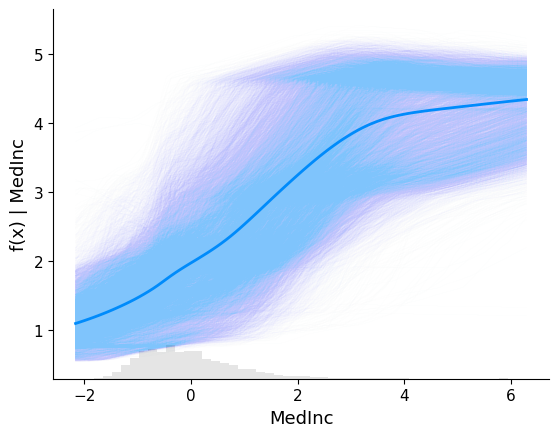


Calculating and plotting PDP for 'HouseAge'...
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
413/4

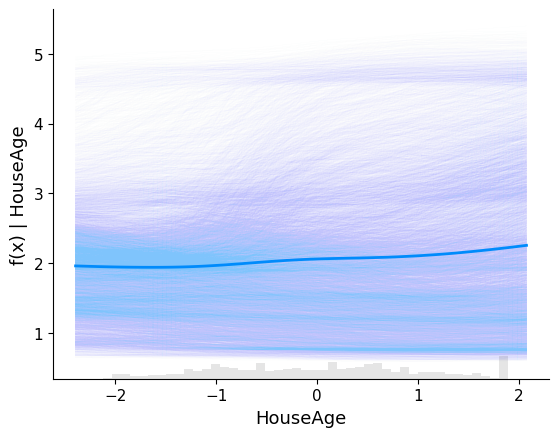

In [ ]:
# California Housing

actual_keras_model = model.model_

original_feature_names = housing.feature_names

predict_fn = lambda X: actual_keras_model.predict(X).ravel()

print("\nCalculating and plotting PDP for 'MedInc'...")
shap.plots.partial_dependence(
    "MedInc",
    predict_fn,
    X_train_scaled,
    feature_names=original_feature_names,
    show=True
)

print("\nCalculating and plotting PDP for 'HouseAge'...")
shap.plots.partial_dependence(
    "HouseAge",
    predict_fn,
    X_train_scaled,
    feature_names=original_feature_names,
    show=True
)

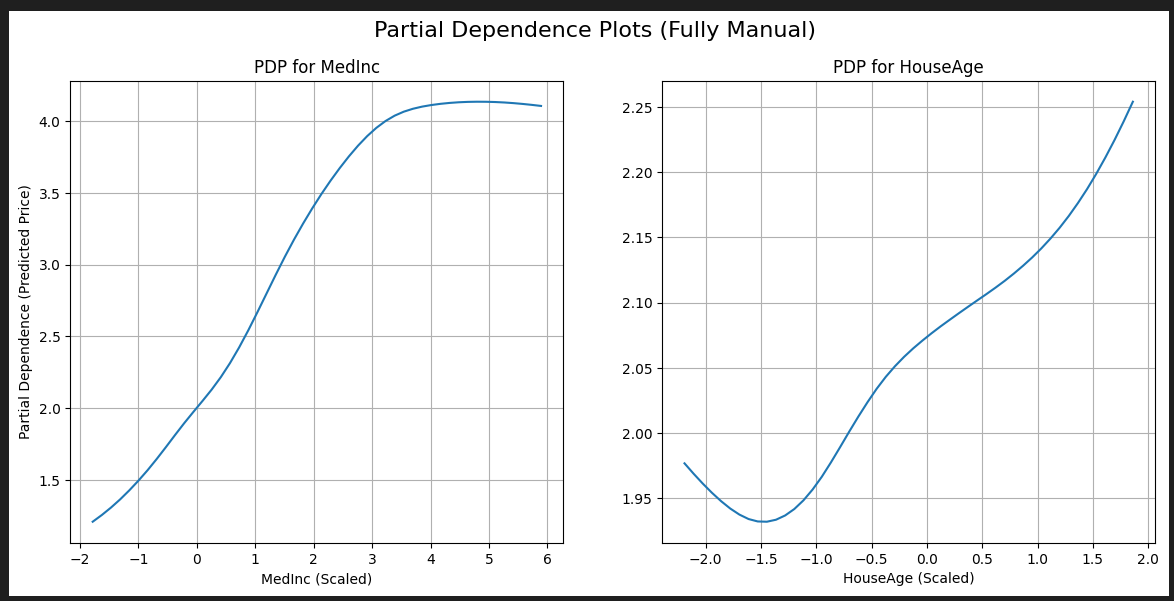

### b. Use ICE plots to explore individual predictions for at least two features. 

In [50]:
#ICE and PDP for California Housing were implemented together in the previous Task

### c. Explain what insights PDP and ICE give about the model’s behaviour.

#### California Housing Dataset

PDP:
- Median Income (MedInc): the plots illustrate a strong positive relationship between the predicted prices and MedInc. Which is also showing non-linear dependance, it rises steeply at first and then plateaus at higher income. Meaning the model has learned that after a certain point more income does not lead to much higher price prediction.
- HouseAge: the graphs show a complex "J" shaped relationship, predicting the lowest prices for houses that are slightly newer than average. Also, it predicts higher prices for both brand new and very old houses. Meaning the model learned two seperate patterns, new and old houses that manage to be sold at a high price.


ICE:
- MedInc: the graph clearly shows that the vast majority of faint blue-purple lines are tightly packed around the main blue PDP line. It indicates that the model's rule is homogeneous and it is applied in almost exact way to every house regardless other features.
- HouseAge: the faint lines are spread all across the range from 1 to 5, signifying that the effect of HouseAge is different for distinct houses. 

## 2. Permutation Feature Importance (PFI) (7 marks) 
### a. Use PFI to identify the most important features in the model. 


Feature		 | Importance (Drop in R-squared)
----------------------------------------
Population	 | 0.0130
AveBedrms 	 | 0.0475
HouseAge  	 | 0.0709
AveRooms  	 | 0.1009
AveOccup  	 | 0.2172
MedInc    	 | 0.5050
Longitude 	 | 0.6737
Latitude  	 | 0.7278


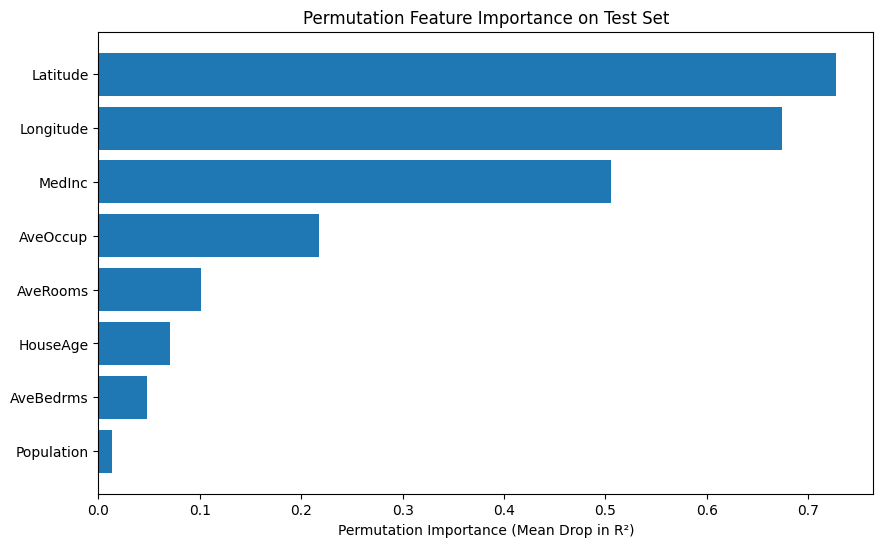

In [65]:
# California Housing Dataset

original_feature_names = housing.feature_names

pfi_results = permutation_importance(
    model,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42,
)

sorted_indices = pfi_results.importances_mean.argsort()

print("Feature\t\t | Importance (Drop in R-squared)")
print("-" * 40)
for i in sorted_indices:
    print(f"{original_feature_names[i]:<10}\t | {pfi_results.importances_mean[i]:.4f}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(
    np.array(original_feature_names)[sorted_indices],
    pfi_results.importances_mean[sorted_indices]
)
ax.set_xlabel("Permutation Importance (Mean Drop in R²)")
ax.set_title("Permutation Feature Importance on Test Set")
plt.show()

### b. Explain what the term “important” means when using the PFI method. 

When using the PFI method, the term "important" means how much the model's performance and its accuracy depend on a specific feature.
It is measured by looking at how much the model's prediction error increases when the data for that certain feature is randomly shuffled.

## 3. Accumulated Local Effects (ALE) (9 marks) 
### a. Implement ALE plots to investigate the local effects of feature changes. 

PyALE._ALE_generic:INFO: Continuous feature detected.


Calculating ALE for 'MedInc'...


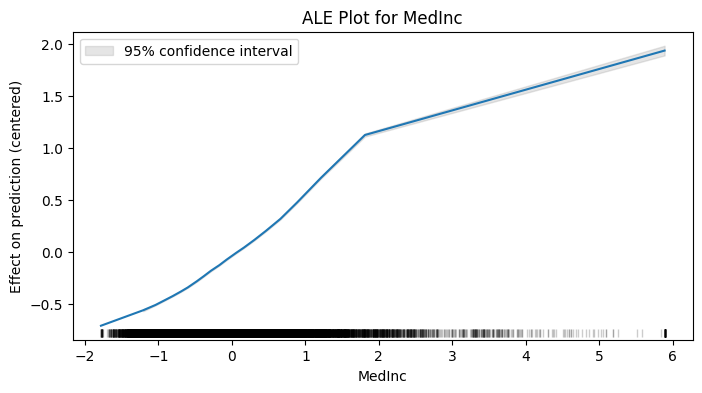

PyALE._ALE_generic:INFO: Continuous feature detected.


Calculating ALE for 'HouseAge'...


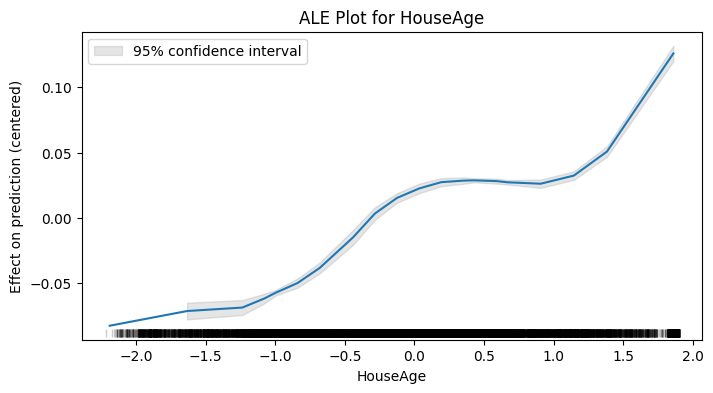

In [ ]:
# California Housing Dataset

original_feature_names = housing.feature_names

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=original_feature_names)

ale_plot_medinc = ale(
    X=X_train_scaled_df,
    model=model,
    feature=["MedInc"],
    plot=True
)
plt.title("ALE Plot for MedInc")
plt.show()

ale_plot_houseage = ale(
    X=X_train_scaled_df,
    model=model,
    feature=["HouseAge"],
    plot=True
)
plt.title("ALE Plot for HouseAge")
plt.show()

### b. Compare ALE with PDP and discuss any differences in the interpretability of these techniques.

California Housing

PDP seems to be simpler, e.g., to see the effect of MedInc, it takes a single value and forces all the house samples in the dataset to have this value, while keeping other features the same. Concequently, thiss might create unrealistic data, like a house with rural location, low income area, and have a MedInc as rich. While ALE acts smarter and safer, avoiding creating unreal data scenarios. It divides the feature into small parts and only looks at real houses in that specific part. It calculates the change in prediction just for those houses and then adds up these local changes across the whole feature.

However, in our case the graphs show similarity in both PDP and ALE. PDP for MedInc shows a steep rise and then plateauing the same as ALE, and even for HouseAge PDP illustrates a dip followed by a steep rise, exactly the same as ALE. Which signifies that even though PDP might be misleading, in this situation, the relationship between MedInc, HouseAge, and other features is not strong enough to significantly influence PDP.

## 4. Global Surrogates (7 marks) 
### a. Build an interpretable model to approximate the predictions of the feed-forward neural network model. 

R-squared (Fidelity): 0.6848


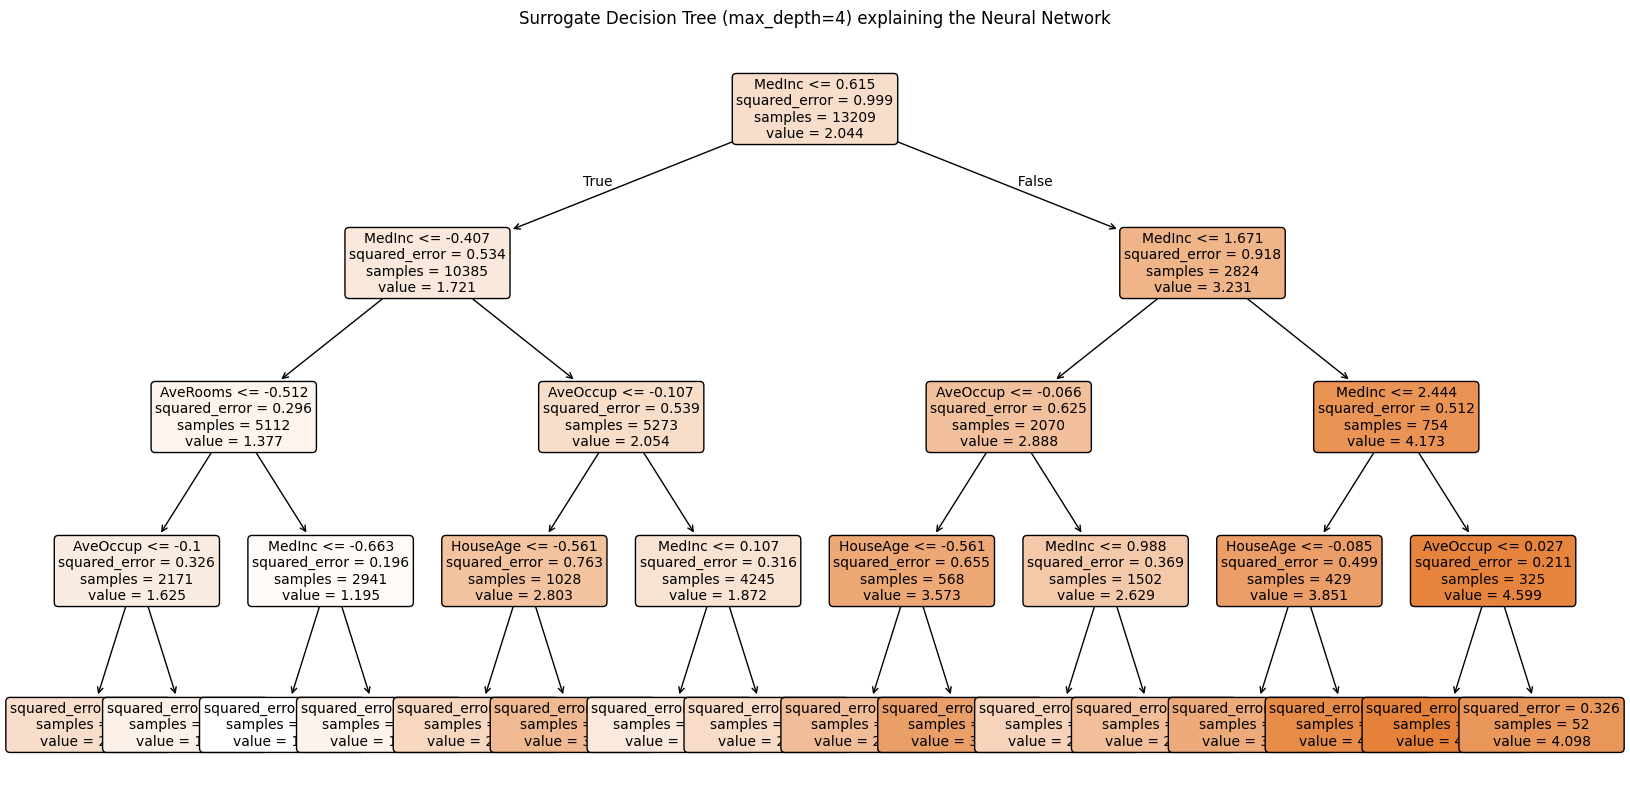

In [ ]:
# California Housing Dataset

nn_predictions_train = model.predict(X_train_scaled)

surrogate_model = DecisionTreeRegressor(max_depth=4, random_state=42)

surrogate_model.fit(X_train_scaled, nn_predictions_train)

nn_predictions_test = model.predict(X_test_scaled)
surrogate_predictions_test = surrogate_model.predict(X_test_scaled)

fidelity_r2 = r2_score(nn_predictions_test, surrogate_predictions_test)

print(f"R-squared (Fidelity): {fidelity_r2:.4f}")

original_feature_names = housing.feature_names
plt.figure(figsize=(20, 10))
plot_tree(
    surrogate_model,
    feature_names=original_feature_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Surrogate Decision Tree (max_depth=4) explaining the Neural Network")
plt.show()

### b. Analyse the surrogate model's effectiveness and discuss when such approximations are helpful.

The Global Surrogate model's R-squared score of 0.6848 indicates a moderate fidelity. A simple, 4-level deep desicion tree was chosen as a surrogate model, which managed to explain 68.5% of the neural network's logic. This decent score shows that the neural network has learned quite a complex and non-linear set of rules that cannot be perfectly captured in a simple and interpretable model. Generally, the use of Global Surrogate models can be very helpful when we need to explain a black box model such as various neural networks and other architectures. Which makes the model be more understandable and easy to interpret.